In [1]:
"""
Figure 5: Astrocytes connected in networks

Intercellular calcium wave propagation in a ring of 50 astrocytes connected by
bidirectional gap junctions (see Goldberg et al., 2010)
"""
from brian2 import *

import plot_utils as pu

set_device('cpp_standalone', directory=None)  # Use fast "C++ standalone mode"

################################################################################
# Model parameters
################################################################################
### General parameters
duration = 4000*second       # Total simulation time
sim_dt = 50*ms               # Integrator/sampling step

### Astrocyte parameters
# ---  Calcium fluxes
O_P = 0.9*umolar/second      # Maximal Ca^2+ uptake rate by SERCAs
K_P = 0.05 * umolar          # Ca2+ affinity of SERCAs
C_T = 2*umolar               # Total cell free Ca^2+ content
rho_A = 0.18                 # ER-to-cytoplasm volume ratio
Omega_C = 6/second           # Maximal rate of Ca^2+ release by IP_3Rs
Omega_L = 0.1/second         # Maximal rate of Ca^2+ leak from the ER
# --- IP_3R kinectics
d_1 = 0.13*umolar            # IP_3 binding affinity
d_2 = 1.05*umolar            # Ca^2+ inactivation dissociation constant
O_2 = 0.2/umolar/second      # IP_3R binding rate for Ca^2+ inhibition
d_3 = 0.9434*umolar          # IP_3 dissociation constant
d_5 = 0.08*umolar            # Ca^2+ activation dissociation constant
# --- IP_3 production
O_delta = 0.6*umolar/second  # Maximal rate of IP_3 production by PLCdelta
kappa_delta = 1.5* umolar    # Inhibition constant of PLC_delta by IP_3
K_delta = 0.1*umolar         # Ca^2+ affinity of PLCdelta
# --- IP_3 degradation
Omega_5P = 0.05/second       # Maximal rate of IP_3 degradation by IP-5P
K_D = 0.7*umolar             # Ca^2+ affinity of IP3-3K
K_3K = 1.0*umolar            # IP_3 affinity of IP_3-3K
O_3K = 4.5*umolar/second     # Maximal rate of IP_3 degradation by IP_3-3K
# --- IP_3 diffusion
F_ex = 0.09*umolar/second    # Maximal exogenous IP3 flow
F = 0.09*umolar/second       # GJC IP_3 permeability
I_Theta = 0.3*umolar         # Threshold gradient for IP_3 diffusion
omega_I = 0.05*umolar        # Scaling factor of diffusion



In [2]:
defaultclock.dt = sim_dt     # Set the integration time

### Astrocytes
astro_eqs = '''
dI/dt = J_delta - J_3K - J_5P + J_ex + J_coupling : mmolar
J_delta = O_delta/(1 + I/kappa_delta) * C**2/(C**2 + K_delta**2) : mmolar/second
J_3K = O_3K * C**4/(C**4 + K_D**4) * I/(I + K_3K)                : mmolar/second
J_5P = Omega_5P*I                                                : mmolar/second
# Exogenous stimulation (rectangular wave with period of 50s and duty factor 0.4)
stimulus = int((t % (50*second))<20*second)                      : 1
delta_I_bias = I - I_bias*stimulus                               : mmolar
J_ex = -F_ex/2*(1 + tanh((abs(delta_I_bias) - I_Theta)/omega_I)) *
                sign(delta_I_bias)                               : mmolar/second
# Diffusion between astrocytes
J_coupling : mmolar/second

# Ca^2+-induced Ca^2+ release:
dC/dt = J_r + J_l - J_p                                   : mmolar
dh/dt = (h_inf - h)/tau_h                                 : 1
J_r = (Omega_C * m_inf**3 * h**3) * (C_T - (1 + rho_A)*C) : mmolar/second
J_l = Omega_L * (C_T - (1 + rho_A)*C)                     : mmolar/second
J_p = O_P * C**2/(C**2 + K_P**2)                          : mmolar/second
m_inf = I/(I + d_1) * C/(C + d_5)                         : 1
h_inf = Q_2/(Q_2 + C)                                     : 1
tau_h = 1/(O_2 * (Q_2 + C))                               : second
Q_2 = d_2 * (I + d_1)/(I + d_3)                           : mmolar

# External IP_3 drive
I_bias : mmolar (constant)
'''

N_astro = 50 # Total number of astrocytes in the network
astrocytes = NeuronGroup(N_astro, astro_eqs, method='rk4')
# Asymmetric stimulation on the 50th cell to get some nice chaotic patterns
astrocytes.I_bias[N_astro//2] = 1.0*umolar
astrocytes.h = 0.9
# Diffusion between astrocytes
astro_to_astro_eqs = '''
delta_I = I_post - I_pre        : mmolar
J_coupling_post = -F/2 * (1 + tanh((abs(delta_I) - I_Theta)/omega_I)) *
                  sign(delta_I) : mmolar/second (summed)
'''
astro_to_astro = Synapses(astrocytes, astrocytes,
                          model=astro_to_astro_eqs)
# astrocytes
astro_to_astro.connect('j == (i + 1) % N_pre or '
                       'j == (i + N_pre - 1) % N_pre')


# Monitors
astro_mon = StateMonitor(astrocytes, variables=['C'], record=True)
run(duration, report='text')

Starting simulation at t=0 s for duration 4000 s
4000 s (100%) simulated in 1s


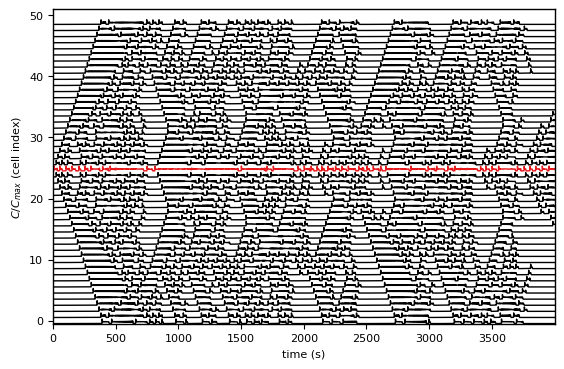

In [3]:
#Plotting
plt.style.use('figures.mplstyle')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6.26894, 6.26894 * 0.66),
                       gridspec_kw={'left': 0.1, 'bottom': 0.12})
scaling = 1.2
step = 10
ax.plot(astro_mon.t/second,
        (astro_mon.C[0:N_astro//2].T/astro_mon.C.max() +
         np.arange(N_astro//2)*scaling), color='black')
ax.plot(astro_mon.t/second, (astro_mon.C[N_astro//2+1:].T/astro_mon.C.max() +
                             np.arange(N_astro//2+1, N_astro)*scaling),
        color='black')
ax.plot(astro_mon.t/second, (astro_mon.C[N_astro//2].T/astro_mon.C.max() +
                             N_astro//2 * scaling),
        color='C0')
ax.set(xlim=(0., duration/second), ylim=(0, (N_astro+1.5)*scaling),
       xticks=np.arange(0., duration/second, 500), xlabel='time (s)',
       yticks=np.arange(0.5*scaling, (N_astro + 1.5)*scaling, step*scaling),
       yticklabels=[str(yt) for yt in np.arange(0, N_astro + 1, step)],
       ylabel='$C/C_{max}$ (cell index)')


plt.show()